In [1]:
# Import necessary modules
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# We load the excel data into a pandas dataframe and concatenate
spring = pd.read_excel('2019-spring-match-data-OraclesElixir-2019-05-21.xlsx')
summer = pd.read_excel('2019-summer-match-data-OraclesElixir-2019-09-16.xlsx')
worlds = pd.read_excel('2019-summer-match-data-OraclesElixir-2019-11-10.xlsx')
df = pd.concat([spring,summer,worlds])

In [3]:
# We clean the dataframe by dropping unwanted columns and reseting the index
df = df.reset_index(drop = True)
df = df.drop(['gameid','url','date','split','week','game'], axis = 1)

In [4]:
# dataframes of just the winning/losing teams and players of the top regions for our training data
# removing weaker regions seems to improve accuracy 

t_df = df[((df.playerid == 100)|(df.playerid == 200)) & ((df.league!='WC') & (df.league!='CBLoL' ) & (df.league!='LMS'))]
p_df = df[~((df.playerid == 100)|(df.playerid == 200)) & ((df.league!='WC') & ( df.league!='CBLoL' ) & (df.league!='LMS'))]
 
wt_df = t_df[t_df.result == 1]
lt_df = t_df[t_df.result == 0]
wp_df = p_df[p_df.result == 1]
lp_df = p_df[p_df.result == 0]

# The data that we eventually want to predict
worlds_t = df[((df.playerid == 100) | (df.playerid == 200)) & (df.league =='WC')]
worlds_p = df[~((df.playerid == 100) | (df.playerid == 200)) & (df.league =='WC')]

#list of all champions
sorted_champs = df.champion.unique()
sorted_champs.sort()
sorted_champs = sorted_champs[1:]

In [5]:
# There are champions that have 0 wins in the pro matches we look at
champ_wr = (wp_df.champion.value_counts() / p_df.champion.value_counts()).fillna(0)
champ_w = (p_df.champion.value_counts()*champ_wr.sort_index())
champ_wr = champ_wr.reindex(sorted_champs).fillna(0)
champ_w = champ_w.reindex(sorted_champs).fillna(0)
champ_wr[champ_wr == 0]

Diana     0.0
Graves    0.0
Maokai    0.0
Name: champion, dtype: float64

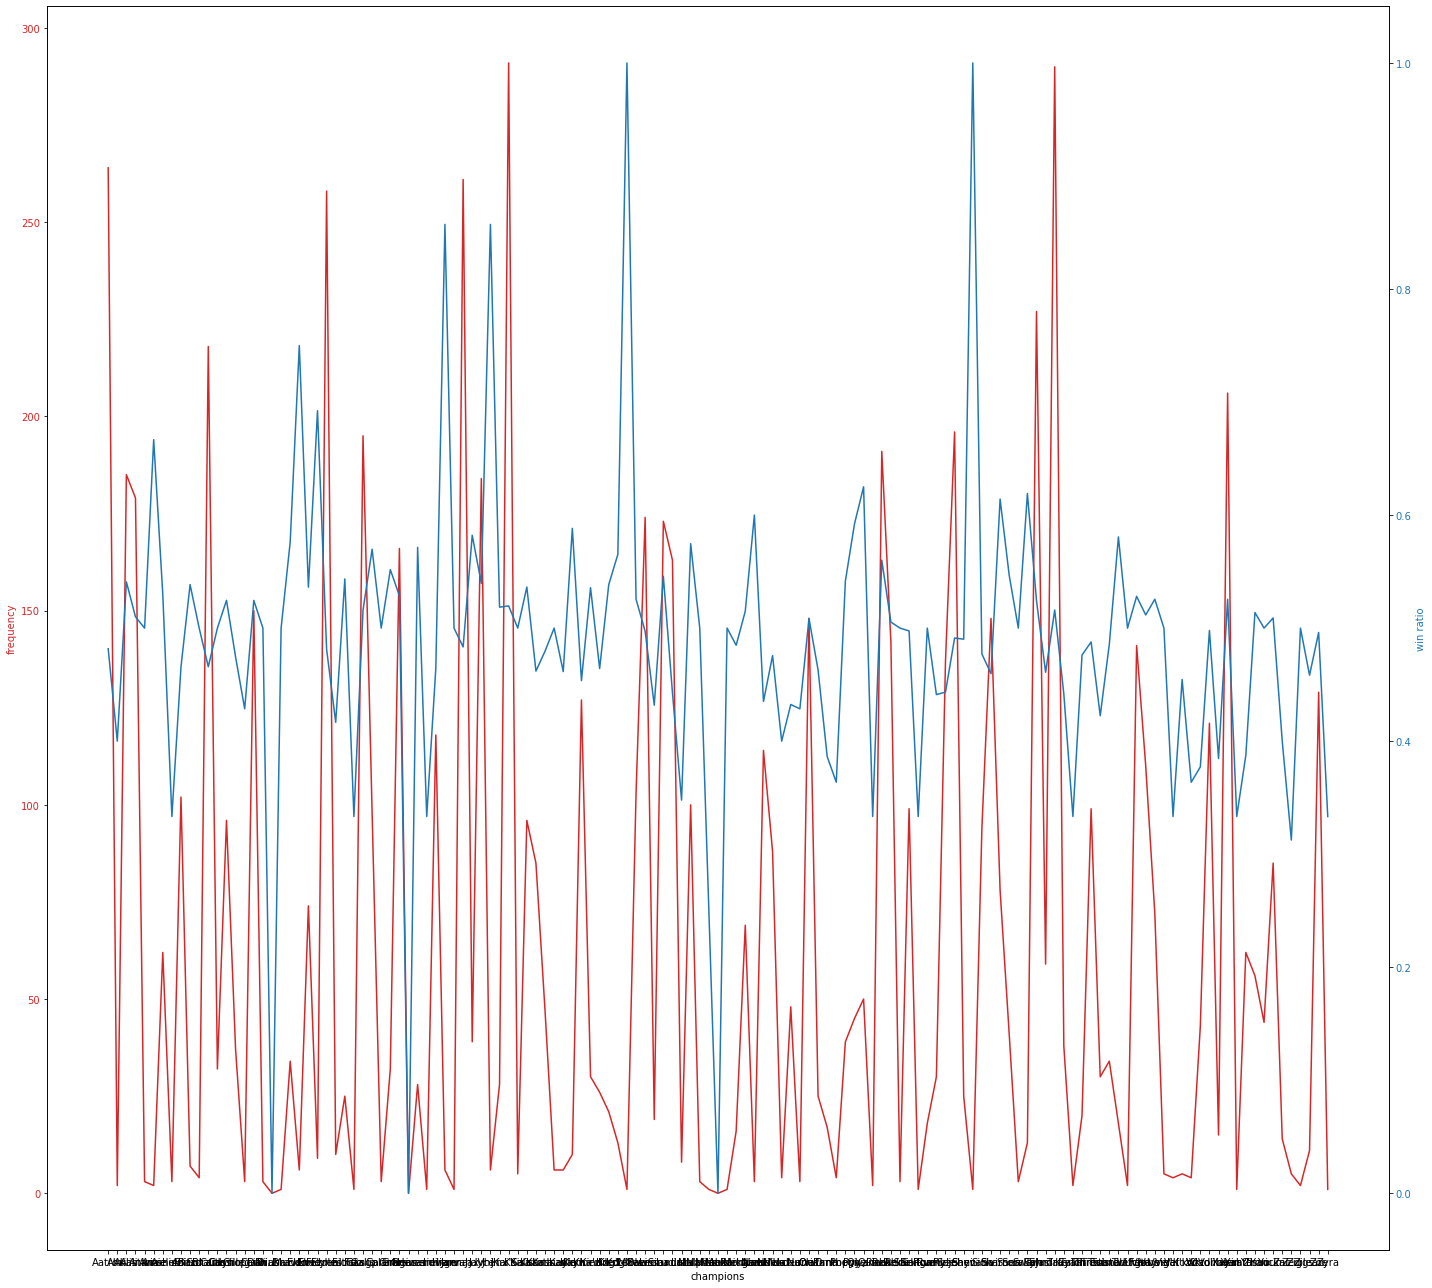

In [6]:
#We plot the frequency with the win rate to try and visualize which champions have high pick and win rate
data1 = champ_w
data2 = champ_wr

fig, ax1 = plt.subplots(figsize = (20,18))

color = 'tab:red'
ax1.set_xlabel('champions')
ax1.set_ylabel('frequency', color=color)
ax1.plot(data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('win ratio', color=color)  # we already handled the x-label with ax1
ax2.plot(data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [7]:
# 53% of games won are from teams on the blue side which may indicate a slight advantage!
wt_df.side.value_counts() / t_df.side.value_counts()

Blue    0.532248
Red     0.467752
Name: side, dtype: float64

In [8]:
# Win percentage for teams reindexing to include teams not in major regions. 
team_wr = (t_df.groupby(['team']).sum().result / t_df.team.value_counts())
team_wr = team_wr.reindex(df.team.unique()).fillna(-1).sort_values(ascending = False)
team_wr

Funplus Phoenix       0.800000
G2 Esports            0.728571
Griffin               0.693182
SK Telecom T1         0.685950
Team Liquid           0.675676
                        ...   
MAD Team             -1.000000
Alpha Esports        -1.000000
Dragon Gate Team     -1.000000
Hong Kong Attitude   -1.000000
GAM Esports          -1.000000
Length: 85, dtype: float64

In [9]:
# We begin to build arrays for each champion using one hot encoding

champ_list = np.array([champ for champ in p_df.champion.tolist()])
result_list = t_df[t_df.side=='Blue'].result.tolist()
champs_in_game = np.array_split(champ_list,len(result_list))

enc = OneHotEncoder()
enc.fit(np.array_split(df[~((df.playerid == 100)|(df.playerid == 200))].champion.to_list(),len(df[((df.playerid == 100)|(df.playerid == 200))].result)/2))

X = enc.transform(champs_in_game)
y = result_list

In [10]:
# We split the data into train and test sets and fit the data using a classifier
# The accuracy is slightly better than random so we could apply some feature engineering to improve our data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7,random_state=42)
clf = ExtraTreesClassifier(n_estimators = 100)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("One Hot Encoding accuracy:",accuracy_score(y_test, y_pred))

One Hot Encoding accuracy: 0.5381526104417671


In [11]:
# Our model does about the same at predicting championship matches

y_worlds = worlds_t[worlds_t.side=='Blue'].result
X_worlds = enc.transform(np.array_split(([champ for champ in worlds_p.champion.tolist()]),len(y_worlds)))
y_pred = clf.predict(X_worlds)
print("One Hot Encoding Championship accuracy:",accuracy_score(y_worlds, y_pred))

One Hot Encoding Championship accuracy: 0.5546218487394958


In [12]:
# We now try using tf/idf and PCA to encode our champions which turns out to be on par with one hot encoding or even worse.
champs = []
for champ in champ_list:
    champ = champ.replace("'", "")
    champ = champ.replace(".", "")
    champ = champ.replace(" ","")
    champs.append(champ)
    
corpus = [] 
for arr in np.array_split(champs,len(result_list)*2):
    corpus.append(arr[0]+ ' '+ arr[1] + ' '+ arr[2] + ' '+ arr[3] + ' '+ arr[4])
    
vectorizer = TfidfVectorizer(min_df=0)
X = vectorizer.fit_transform(corpus)
svd = TruncatedSVD(n_components=5, random_state=42)
X_reduced = np.array_split(np.concatenate(svd.fit_transform(X)),len(y))
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, train_size=0.7,random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("tf-idf with PCA training accuracy:",accuracy_score(y_test, y_pred))

tf-idf with PCA training accuracy: 0.5220883534136547


In [13]:
# find player winrate on specific champion, we set the window as the max number of games a player played one champion
rolling_wr = p_df.groupby(['player','champion'])['result'].rolling(window = p_df.groupby(['player','champion'])['result'].count().max(),min_periods=1).mean().reset_index()
rolling_wr = rolling_wr.rename(columns={'result':'rolling_wr'})
rolling_wr.loc[:,'index'] = p_df.reset_index(drop = True).reset_index().groupby(['player','champion','index'],as_index = False)['result'].count()['index']
rolling_wr = rolling_wr.sort_values('index')
shifted_rolling = rolling_wr.groupby(['player','champion'], as_index = False)['rolling_wr'].shift(1)
shifted_rolling.loc[:,'order'] = rolling_wr['index']
shifted_rolling = shifted_rolling.sort_values('order')
p_df.loc[:,'rolling_wr'] = rolling_wr.rolling_wr.values
p_df.loc[:,'shifted_rolling'] = shifted_rolling.rolling_wr.values
p_df = p_df.fillna(-1)
p_df

C:\Users\Sreekar\Anaconda3\envs\NLP\lib\site-packages\pandas\core\indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Sreekar\Anaconda3\envs\NLP\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


league  patchno  playerid  side position      player    team   champion  \
0        LEC     9.01         1  Blue      Top       Bwipo  Fnatic       Sion   
1        LEC     9.01         2  Blue   Jungle      Broxah  Fnatic    Lee Sin   
2        LEC     9.01         3  Blue   Middle     Nemesis  Fnatic      Akali   
3        LEC     9.01         4  Blue      ADC     Rekkles  Fnatic     Lucian   
4        LEC     9.01         5  Blue  Support   Hylissang  Fnatic       Pyke   
...      ...      ...       ...   ...      ...         ...     ...        ...   
25469    LEC     9.16         6   Red      Top  Vizicsacsi  Splyce  Gangplank   
25470    LEC     9.16         7   Red   Jungle       Xerxe  Splyce    Sejuani   
25471    LEC     9.16         8   Red   Middle    Humanoid  Splyce      Yasuo   
25472    LEC     9.16         9   Red      ADC       Kobbe  Splyce     Kai'Sa   
25473    LEC     9.16        10   Red  Support   Norskeren  Splyce       Shen   

         ban1      ban2  ... oppxpat10 xpdat10 csat10  oppcsat10  csdat10  \
0      Irelia  Xin Zhao  ...    4689.0  -136.0   79.0       83.0     -4.0   
1      Irelia  Xin Zhao  ...    3537.0  -123.0   54.0       54.0      0.0   
2      Irelia  Xin Zhao  ...    5336.0  -720.0   88.0      105.0    -17.0   
3      Irelia  Xin Zhao  ...    3518.0  -157.0   99.0       93.0      6.0   
4      Irelia  Xin Zhao  ...    2609.0   -94.0   14.0       15.0     -1.0   
...       ...       ...  ...       ...     ...    ...        ...      ...   
25469   Yuumi     Akali  ...    4806.0  -725.0   76.0       87.0    -11.0   
25470   Yuumi     Akali  ...    2790.0   307.0   53.0       49.0      4.0   
25471   Yuumi     Akali  ...    4763.0    82.0   96.0       89.0      7.0   
25472   Yuumi     Akali  ...    3867.0 -1027.0   75.0       85.0    -10.0   
25473   Yuumi     Akali  ...    2453.0   216.0   14.0       14.0      0.0   

       csat15  oppcsat15  csdat15  rolling_wr  shifted_rolling  
0       134.0      139.0     -5.0    0.000000        -1.000000  
1        97.0       91.0      6.0    0.000000        -1.000000  
2       154.0      154.0      0.0    0.000000        -1.000000  
3       147.0      153.0     -6.0    0.000000        -1.000000  
4        22.0       25.0     -3.0    0.000000        -1.000000  
...       ...        ...      ...         ...              ...  
25469   129.0      115.0     14.0    0.615385         0.666667  
25470    72.0       76.0     -4.0    0.166667         0.200000  
25471   140.0      138.0      2.0    0.000000         0.000000  
25472   113.0      140.0    -27.0    0.615385         0.666667  
25473    23.0       22.0      1.0    0.000000         0.000000  

[16590 rows x 94 columns]

In [14]:
# merge dataframes
player_wr = p_df.groupby(['player','champion'],as_index = False)['result'].mean()
player_wr = player_wr .rename(columns={'result':'wr_on_champ'})
worlds_p = worlds_p.merge(player_wr, on=['player','champion'],how='left').fillna(-1)

In [15]:
# We are overfitting because the rolling wr already contains the match result for the first game played so we need to shift our values.
X1 = np.array_split(p_df['rolling_wr'],len(result_list))
y1 = y
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, train_size=0.8,shuffle = False)
clf.fit(X1_train, y1_train)
y1_pred = clf.predict(X1_test)
print("rolling_wr training accuracy:",accuracy_score(y1_test, y1_pred))

rolling_wr training accuracy: 0.9759036144578314


In [16]:
# We obtain our best accuracy on championship dataset by effectively "agressively guessing"
X1_worlds = np.array_split(worlds_p['wr_on_champ'].values,len(y_worlds))
y1_worlds = y_worlds
y1_pred = clf.predict(X1_worlds)
print("rolling_wr Championship accuracy:",accuracy_score(y1_worlds, y1_pred))

rolling_wr Championship accuracy: 0.6302521008403361


In [17]:
# After shifting we remove overfitting
X1 = np.array_split(p_df['shifted_rolling'],len(result_list))
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, train_size=0.8,shuffle = False)
clf.fit(X1_train, y1_train)
y1_pred = clf.predict(X1_test)
print("shifted_rolling_wr train_test_split accuracy:",accuracy_score(y1_test, y1_pred))

shifted_rolling_wr train_test_split accuracy: 0.5301204819277109


In [18]:
# But we have a significant decrease in accuracy
y1_pred = clf.predict(X1_worlds)
print("shifted_rolling_wr Championship accuracy:",accuracy_score(y1_worlds, y1_pred))

shifted_rolling_wr Championship accuracy: 0.5210084033613446


In [19]:
# We have more type 1 errors than type 2 which implies our model is currently predicting losses better than wins
confusion_matrix(y1_worlds, y1_pred)

array([[24, 33],
       [24, 38]], dtype=int64)

In [20]:
# Our model does well at predicting certain parts of our dataset over others which indicates that the missing data may be the
# reason for low accuracy
scores = cross_val_score(clf, X1_worlds, y1_worlds, cv=5)
print(scores)

[0.70833333 0.58333333 0.54166667 0.54166667 0.43478261]


In [21]:
# We construct a dataframe with each lane matchup and the winrate.

matchup = pd.DataFrame(data = [pd.concat([p_df.champion[p_df.side == 'Blue'],p_df.champion[p_df.side == 'Red']]).reset_index().champion,
                               pd.concat([p_df.champion[p_df.side == 'Red'],p_df.champion[p_df.side == 'Blue']]).reset_index().champion,
                               pd.concat([p_df.result[p_df.side == 'Blue'], p_df.result[p_df.side == 'Red']]).reset_index().result]) 
matchup = matchup.transpose()
matchup.columns = ['champion1','champion2','wr']
matchup.wr = pd.to_numeric(matchup.wr)
matchup = matchup.groupby(['champion1','champion2'],as_index = False)['wr'].mean()
matchup_table = matchup.pivot_table(values = 'wr', columns = 'champion1',index = 'champion2').fillna(-1)

In [22]:
matchup_wr = []
for c1,c2 in zip(p_df.champion[p_df.side == 'Blue'],p_df.champion[p_df.side == 'Red']):
    matchup_wr.append(matchup_table[c1][c2])
matchup_wr = np.array_split(matchup_wr,len(result_list))
matchup_wr

[array([0.        , 0.51612903, 0.23076923, 0.475     , 0.6       ]),
 array([0.75      , 0.75      , 0.42424242, 0.33333333, 0.52173913]),
 array([0.71428571, 0.51515152, 0.75      , 0.2       , 0.65      ]),
 array([0.56060606, 0.44      , 0.23076923, 0.4       , 0.42528736]),
 array([0.43939394, 0.66666667, 0.28571429, 0.        , 0.52173913]),
 array([0.62962963, 0.5       , 0.4       , 0.59482759, 0.5       ]),
 array([0.41666667, 0.75      , 0.52      , 0.475     , 0.33333333]),
 array([0.53846154, 0.4       , 0.        , 0.33333333, 0.35714286]),
 array([0.45454545, 0.88888889, 0.52      , 0.52380952, 0.29268293]),
 array([0.        , 0.75      , 0.4       , 0.        , 0.57352941]),
 array([0.2       , 0.56      , 0.69230769, 0.40517241, 0.42528736]),
 array([0.33333333, 0.2       , 0.30769231, 0.51612903, 0.57471264]),
 array([0.6       , 0.33333333, 1.        , 0.66666667, 1.        ]),
 array([0.33333333, 0.        , 0.25      , 0.37931034, 0.36363636]),
 array([1.        , 

In [23]:
# We are overfitting again
X2 = [np.append(game,wr) for game,wr in zip(X1,matchup_wr)]
y2 = y

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, train_size=0.8)
clf.fit(X2_train, y2_train)
y2_pred = clf.predict(X2_test)
print("matchup_wr training accuracy:",accuracy_score(y2_test, y2_pred))

matchup_wr training accuracy: 0.786144578313253


In [24]:
worlds_matchup = []
for c1,c2 in zip(worlds_p.champion[worlds_p.side == 'Blue'],worlds_p.champion[worlds_p.side == 'Red']):
    worlds_matchup.append(matchup_table[c1][c2])
worlds_matchup = np.array_split(worlds_matchup,len(y_worlds))

In [25]:
# We have a decrease in accuracy
X2_worlds = [np.append(game,wr) for game,wr in zip(X1_worlds,worlds_matchup)]
y2_worlds = y_worlds
y2_pred = clf.predict(X2_worlds)
print("Championship Accuracy:",accuracy_score(y2_worlds, y2_pred))

Championship Accuracy: 0.5294117647058824


In [26]:
scores = cross_val_score(clf, X2_worlds, y2_worlds, cv=6)
scores

array([0.55      , 0.8       , 0.55      , 0.7       , 0.6       ,
       0.47368421])

In [27]:
clf.feature_importances_

array([0.03989734, 0.0420977 , 0.03791678, 0.04269385, 0.03865945,
       0.04360307, 0.03973512, 0.0374486 , 0.0418101 , 0.04133399,
       0.13417146, 0.10665269, 0.16703052, 0.08908936, 0.09785997])

In [28]:
bans_list = []
bans = t_df.loc[:,['team','ban1','ban2','ban3','ban4','ban5']]
for i in range(0,len(bans),2):
    bans_list.append(bans.team.iloc[i+1])
    bans_list.append(bans.team.iloc[i])
bans.loc[:,'team'] = bans_list
bans = pd.melt(bans, id_vars=['team'],value_name = 'champions')
bans = bans.pivot_table(index = 'team',columns = 'champions',aggfunc = 'count')
bans.columns = bans.columns.droplevel()
bans = bans.reindex(sorted_champs,axis = 1).fillna(0)
bans

champions             Aatrox  Ahri  Akali  Alistar  Anivia  Annie  Ashe  \
team                                                                      
100 Thieves              7.0   0.0    8.0      3.0     0.0    0.0   0.0   
Afreeca Freecs          14.0   0.0   12.0      3.0     0.0    0.0   0.0   
Bilibili Gaming         20.0   0.0    6.0      8.0     0.0    0.0   2.0   
Bombers                  0.0   0.0    0.0      0.0     0.0    0.0   0.0   
Cloud9                  11.0   0.0   10.0      4.0     0.0    0.0   0.0   
Clutch Gaming            4.0   0.0   19.0      5.0     0.0    0.0   0.0   
Counter Logic Gaming     8.0   2.0    2.0      2.0     0.0    0.0   0.0   
Damwon Gaming           11.0   0.0   23.0     11.0     0.0    0.0   2.0   
DetonatioN FocusMe       0.0   0.0    0.0      0.0     0.0    0.0   0.0   
Dominus Esports         12.0   0.0    4.0      0.0     0.0    0.0   0.0   
Echo Fox                 9.0   0.0    4.0      0.0     0.0    0.0   0.0   
Edward Gaming            7.0   0.0   21.0      8.0     0.0    0.0   5.0   
Excel Esports           10.0   0.0    3.0      1.0     0.0    0.0   0.0   
Fenerbahce Esports       0.0   0.0    0.0      1.0     0.0    0.0   0.0   
Flash Wolves             0.0   0.0    4.0      0.0     0.0    0.0   0.0   
FlyQuest                 7.0   0.0   12.0      3.0     0.0    0.0   0.0   
Fnatic                  27.0   0.0    9.0      3.0     0.0    0.0   0.0   
Funplus Phoenix         16.0   0.0   13.0      9.0     0.0    0.0   0.0   
G2 Esports               5.0   0.0   18.0      2.0     0.0    0.0   0.0   
Gen.G                   14.0   0.0   12.0      5.0     0.0    0.0   3.0   
Golden Guardians         6.0   0.0    5.0      0.0     6.0    0.0   0.0   
Griffin                 15.0   0.0   27.0      4.0     0.0    0.0   2.0   
Hanwha Life Esports      9.0   0.0    5.0      6.0     0.0    0.0  11.0   
INTZ e-Sports            0.0   3.0    0.0      0.0     0.0    0.0   1.0   
Invictus Gaming         21.0   0.0   42.0      4.0     0.0    0.0   2.0   
Isurus Gaming            0.0   0.0    2.0      0.0     0.0    0.0   0.0   
JD Gaming               14.0   0.0    3.0     10.0     0.0    0.0   1.0   
Jin Air Green Wings      9.0   0.0    6.0      1.0     0.0    0.0   3.0   
KT Rolster               9.0   0.0    8.0      6.0     0.0    0.0   2.0   
Kingzone DragonX         5.0   0.0    9.0     13.0     0.0    0.0   0.0   
LGD Gaming              11.0   0.0   15.0      9.0     0.0    0.0   3.0   
LNG Esports             17.0   0.0   22.0      4.0     0.0    0.0   0.0   
MEGA Esports             0.0   0.0    0.0      0.0     0.0    0.0   0.0   
Misfits                  1.0   0.0    6.0      2.0     0.0    0.0   0.0   
OMG                     20.0   0.0   16.0      4.0     0.0    0.0   0.0   
OpTic Gaming             5.0   0.0    9.0      2.0     0.0    0.0   0.0   
Origen                   6.0   0.0    4.0      3.0     0.0    0.0   0.0   
Phong Vu Buffalo         0.0   0.0   11.0      2.0     0.0    0.0   0.0   
Rogue                    7.0   0.0    3.0      4.0     0.0    0.0   0.0   
Rogue Warriors          24.0   0.0    1.0      7.0     0.0    0.0   1.0   
Royal Never Give Up      8.0   0.0    8.0     11.0     0.0    0.0   0.0   
SK Gaming               11.0   0.0    6.0      7.0     0.0    0.0   1.0   
SK Telecom T1           25.0   0.0   16.0      6.0     0.0    0.0   4.0   
Sandbox Gaming          21.0   0.0   16.0      2.0     0.0    0.0   0.0   
Schalke 04               9.0   0.0    8.0      4.0     0.0    0.0   2.0   
SinoDragon Gaming        9.0   0.0    5.0      3.0     0.0    0.0   0.0   
Snake Esports           11.0   0.0   13.0      3.0     0.0    0.0   0.0   
Splyce                   9.0   0.0    9.0      1.0     0.0    0.0   0.0   
Suning                  20.0   0.0   10.0      2.0     0.0    0.0   1.0   
Team Liquid             13.0   0.0   13.0      2.0     0.0    0.0   1.0   
Team SoloMid            11.0   0.0   24.0      3.0     0.0    0.0   0.0   
Team WE                 1

In [42]:
# We define ban_score as the number of bans against a certain champion per team based on how many games the team has played
ban_score = [(5*bans[champ][team]/t_df.team.value_counts()[team]) for team,champ in zip(p_df.team,p_df.champion)]
p_df['ban_score'] = ban_score
p_df.ban_score

0        0.000000
1        0.873016
2        0.714286
3        0.396825
4        0.476190
           ...   
25469    0.603448
25470    0.172414
25471    0.000000
25472    0.258621
25473    0.431034
Name: ban_score, Length: 16590, dtype: float64

In [43]:
# We obtain a similar accuracy to other features.
X3 = np.array_split(p_df['ban_score'],len(result_list))
y3 = y
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, train_size=0.8,shuffle = False)
clf.fit(X3_train, y3_train)
y3_pred = clf.predict(X3_test)
print("ban_score training accuracy:",accuracy_score(y3_test, y3_pred))

ban_score training accuracy: 0.5542168674698795
